Edwin Bosch

Original Credit: Carly Raskin and Edwin Bosch in collaboration

Citation request: Raskin, Carly, and Edwin Bosch. “Machine Learning Project 3.” Google Colab, Google, 21 Aug. 2022, colab.research.google.com/drive/1YCCf4URJTFhsEHbFTnlWrdDCp6ylWhY5. 

# **Experiment Objective**
---

Our object is to identify images of cars, planes, and motorbikes via a convolutional neural network.

# **Data Collection and Preprocessing**
---

In [2]:
from google.colab import drive
google_drive_root='Project03'
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/Machine Learning/' + google_drive_root + '/'
drive.mount(google_drive_mount_location)

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [4]:
# declare directory prefixes for train and test datasets
data_dir_train = google_file_prefix+"images/_train"
data_dir_validate = google_file_prefix+"images/_validate"
data_dir_test = google_file_prefix+"images/_test"

#this is defined here along with other constants
num_epochs = 5
num_steps = 12

Here we load our image datasets

In [5]:
# load the data
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       image_size=(256, 256),
                                                       labels="inferred",
                                                       label_mode="categorical")
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_validate,
                                                       image_size=(256, 256),
                                                       labels="inferred",
                                                       label_mode="categorical")
sp_test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                       image_size=(256, 256),
                                                       labels="inferred",
                                                       label_mode="categorical")
class_names = train_ds.class_names
class_names

Found 2160 files belonging to 3 classes.
Found 323 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


['airplane', 'car', 'motorbike']

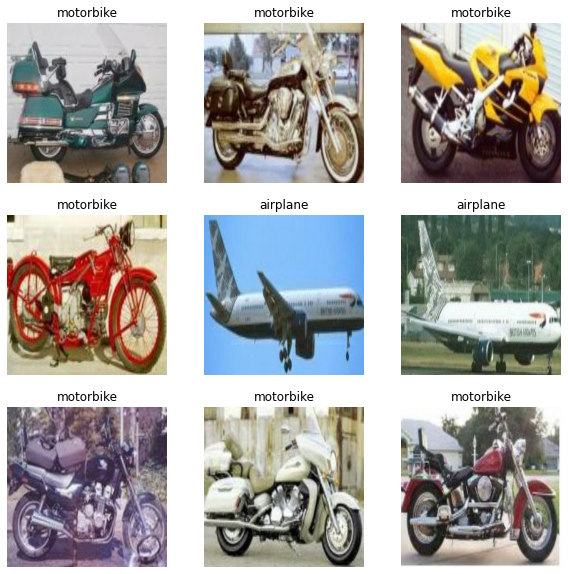

In [6]:
# this is purely a graph
def fixer(tensor):
  if tensor[0] == 1:
    return 0
  elif tensor[1] == 1:
    return 1
  else:
    return 2

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[fixer(labels[i])])
    plt.axis("off")


# **TensorFlow Model Creation**
---

### Explanation

We chose the two imput convolutional layers because they provide a basic starting place for image analysis. We added two large hidden layers for better accuracy and found good results.

After tinkering some more it seems a large third hidden layer at the beginning of the hidden layers is not that helpful or computationaly feasible. This is true of larger opening layers as well as deeper (6+) hidden layers. The one layer model is the best at correctly identifying both the training and the validation/test images.

However in the end the model can only perform as well as the size of the dataset. With thousands more or millions of images, this model could be trained arbitrarily well.

In [7]:

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", 
                                 input_shape=(256, 256, 3)))

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=512, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(3, activation="softmax", name='decoder_dense'))


In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 pool_2 (MaxPooling2D)       (None, 126, 126, 32)      0         
                                                                 
 flatten (Flatten)           (None, 508032)            0         
                                                                 
 fc_1 (Dense)                (None, 512)               260112896 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 decoder_dense (Dense)       (None, 3)                 1

# **Model Training**
---

4 deep:0.7422

6 deep:worse

1 deep:0.7943, 0.7585

2 deep:0.6667, 0.6285

half-width:0.8490, 0.8916

quater-width:0.7760, 0.8545

half-width again (512):0.8333, 0.8545

From some trail and error it seems that one small hidden layer inside the convolutional context works best for a reasonable amount of computing power. I suspect a server farm could produce better results with an enormous network, but here all the additional neurons seem to do is add noise.

In [9]:
result = model.fit(train_ds, epochs = num_epochs, 
                   steps_per_epoch=num_steps,
                   validation_data=test_ds)

Epoch 1/5
12/12 [==============================] - 115s 10s/step - loss: 4998.4321 - accuracy: 0.4453 - val_loss: 1.9164 - val_accuracy: 0.6316
Epoch 2/5
12/12 [==============================] - 93s 8s/step - loss: 1.0365 - accuracy: 0.6901 - val_loss: 0.8862 - val_accuracy: 0.7059
Epoch 3/5
12/12 [==============================] - 86s 7s/step - loss: 0.9031 - accuracy: 0.6745 - val_loss: 0.7972 - val_accuracy: 0.6502
Epoch 4/5
12/12 [==============================] - 88s 7s/step - loss: 0.8744 - accuracy: 0.7031 - val_loss: 0.7976 - val_accuracy: 0.7214
Epoch 5/5
12/12 [==============================] - 87s 7s/step - loss: 0.6851 - accuracy: 0.8151 - val_loss: 0.7276 - val_accuracy: 0.7276


# **Model Evaluation**
---

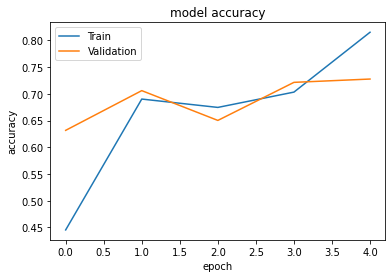

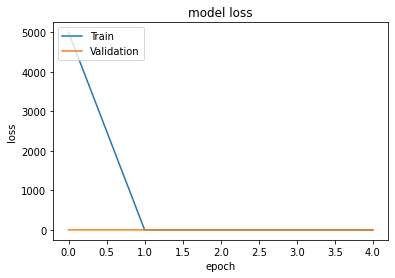

In [10]:
history = result
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
def item_prediction(new_image):
  test_image = tf.keras.preprocessing.image.load_img(new_image, target_size = (256,256))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()

  test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)
 
  predicted_array = model.predict(test_image)
  print(predicted_array)
  print(np.argmax(predicted_array))
  predicted_value = class_names[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your picture is ", predicted_value, " with ", predicted_accuracy, " % accuracy")


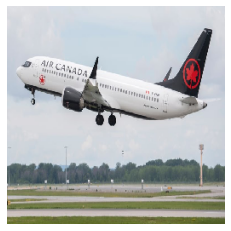

[[0.38086525 0.32859534 0.2905394 ]]
0
Your picture is  airplane  with  38.09  % accuracy


In [12]:
item_prediction(google_file_prefix+"airplane_.jpg")

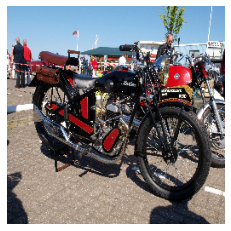

[[0.1902698 0.6205668 0.1891634]]
1
Your picture is  car  with  62.06  % accuracy


In [13]:
item_prediction(google_file_prefix+"motorbike_.jpg")

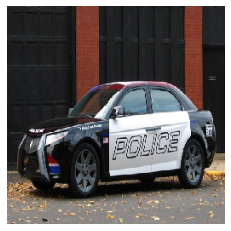

[[0.03901497 0.91511124 0.04587381]]
1
Your picture is  car  with  91.51  % accuracy


In [14]:
item_prediction(google_file_prefix+"car_.jpg")

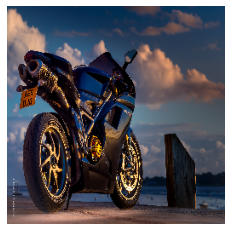

[[0.03670696 0.9152879  0.04800517]]
1
Your picture is  car  with  91.53  % accuracy


In [15]:
item_prediction(google_file_prefix+"hard_motorbike.jpg")

In [16]:
evaluation = model.evaluate(test_ds, return_dict=True, verbose=1)
print("Accuracy on validation data: " + str(int(100*evaluation["accuracy"])) + "%")

11/11 [==============================] - 13s 1s/step - loss: 0.7276 - accuracy: 0.7276
Accuracy on validation data: 72%


In [17]:
evaluation = model.evaluate(sp_test_ds, return_dict=True)
print("Accuracy on test data: " + str(int(100*evaluation["accuracy"])) + "%")


1/1 [==============================] - 2s 2s/step - loss: 3.4736 - accuracy: 0.4000
Accuracy on test data: 40%


# Conclusion

Our model did indeed perform pretty well. However it seems that identifying cars from motorbikes is not an easy conclusion in general, and in particular for a computationally limited network.